### Training Doc2Vec on German Poltical Speeches 

Training Doc2Vec on 1912 transcribed videos from the officla channels of both the far righ-wing party Afd in Germany und the left party Die Linke.

In [ ]:
#Install dependincies
%pip install gensim
pip install pypet
%matplotlib inline

Importing libraries

In [1]:
import gensim.models.doc2vec as d2v
import nltk
from pypet import progressbar
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

Setting up dicrecotry path

In [2]:
cd "/Users/noursafadi/Documents/Uni/Parsons-Spring-25/MajorStudio02/Thesis/political_ai/Political-Speech-Model"

/Users/noursafadi/Documents/Uni/Parsons-Spring-25/MajorStudio02/Thesis/political_ai/Political-Speech-Model


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Loading my data

In [3]:
DATASETPATH = "data/combined_dataset.json"

with open(DATASETPATH, "r", encoding="utf-8") as file:
    data = json.load(file)

In [4]:
#get a dataset that have only the labels and text
for item in data:
    item.pop("score", None)
    item.pop("title", None)

## Training Round two

This notebook is aiming to further clean the data and change the parameters to improve the model. 

01. Changing the length of the speeches to all have the same length

In [ ]:
chunked_data = []

for item in data:
    transcript = item["transcript"]
    words = transcript.split()
    word_count = len(words)
    
    # If the speech is under 500 words, keep it as is
    if word_count <= 600:
        chunked_data.append({
            "labels": item["party"],
            "transcript": transcript
        })
    # Otherwise, split into chunks of maximum 500 words
    else:
        chunk_count = (word_count // 600) + (1 if word_count % 600 > 0 else 0)
        
        for i in range(chunk_count):
            start_idx = i * 600
            end_idx = min(start_idx + 600, word_count)
            
            chunk_transcript = " ".join(words[start_idx:end_idx])
            
            chunked_data.append({
                "labels": item["party"],
                "transcript": chunk_transcript,
            })
print(len(chunked_data[10]["transcript"].split()))
chunked_data[1001]

600


{'labels': 'AFD',
 'transcript': 'ein großes Thema und auch ein großes Problem, der ländliche Raum, fehlende Infrastruktur. Es ist unattraktiv für Arbeitgeber, Fachkräfte wandern ab. Sie waren ja, bevor Sie hier Bundestagsabgeordneter waren, selbst für einige Zeit im Landtag als Landtagsabgeordneter. Nimmt sich die Landesregierung derzeit ja unter Ramelow noch in Thüringen diesem Problem des ländlichen Raumes genügend an? Lange Frage, kurze Antwort oder muss ich es anders machen? Nein, einfach nein. Es ist ja auch nicht nur der ländliche Raum. Ich sage mal, Gera ist ja jetzt nicht nur ländlicher Raum, sondern ist ja fast eine Großstadt. Aber auch da haben wir einige Ortsteile, die ein bisschen entfernt liegen vom Zentrum von Gera. Schon riesengroße Probleme. Also Thüringen ist eigentlich ein kleines Land. Wir haben zwei Millionen Einwohner. Die größte Stadt ist Erfurt. Die hat nicht mal 250.000 Einwohner. Also wenn man mit Menschen aus China beispielsweise, aus Japan, die wir jetzt auc

Ploting out the dataset <br>
Ploting each speech to see:
1. charachters length 
2. Words length

Also getting describtive statistics for the dataset

Character Length Statistics:
count    5709.000000
mean     3249.876160
std      1121.614583
min         5.000000
25%      3136.000000
50%      3728.000000
75%      3921.000000
max      4947.000000
Name: char_length, dtype: float64

Word Count Statistics:
count    5709.000000
mean      501.790857
std       172.739097
min         1.000000
25%       468.000000
50%       600.000000
75%       600.000000
max       600.000000
Name: word_length, dtype: float64


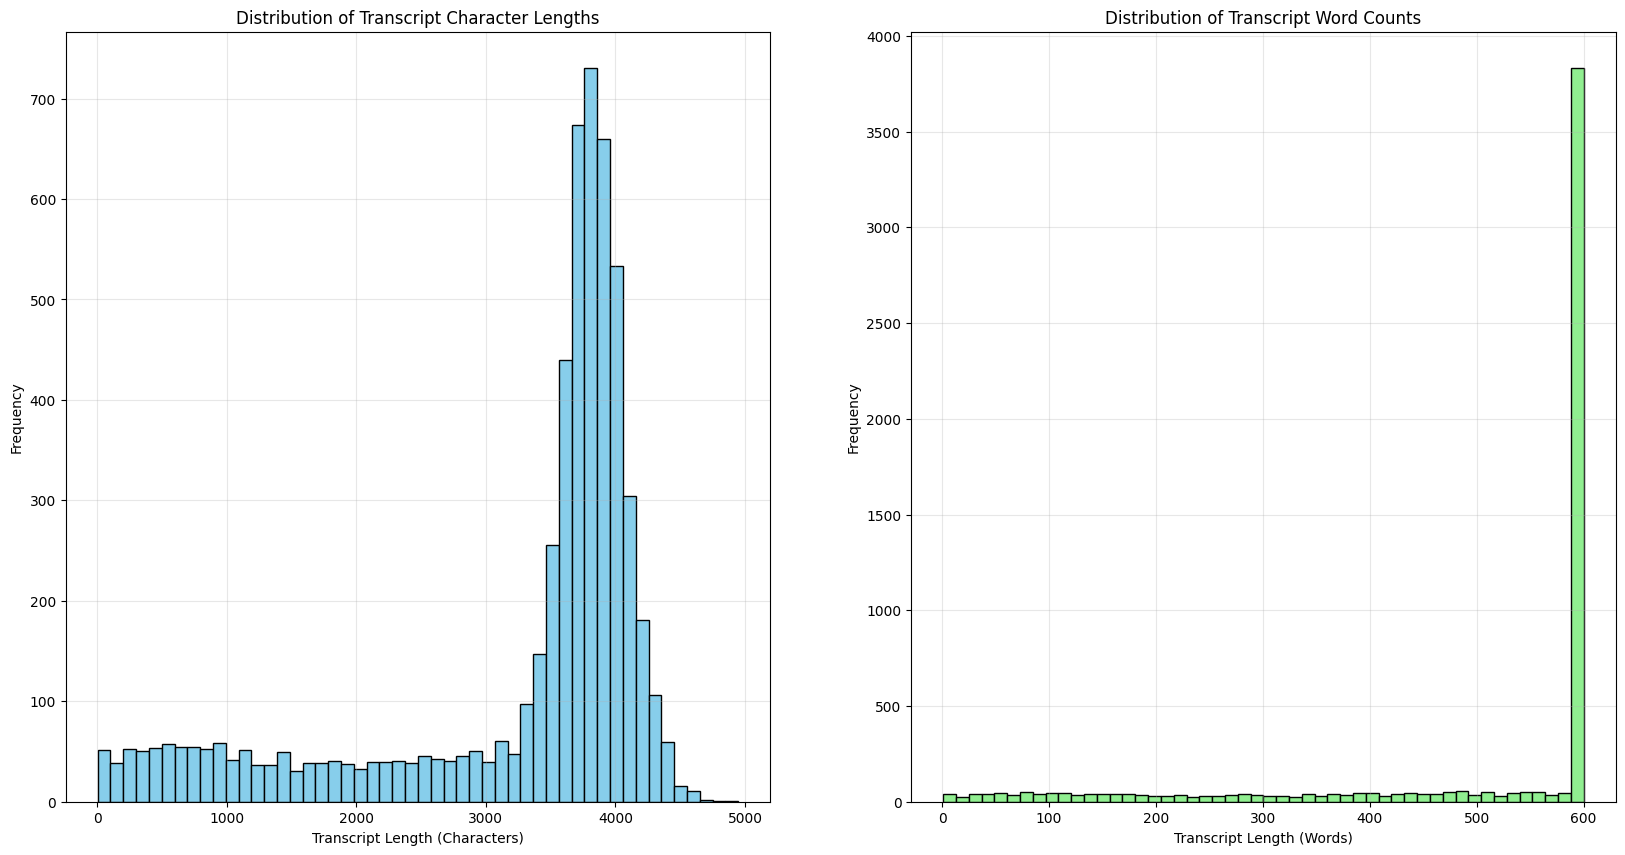

In [ ]:
char_lengths = []
word_lengths = []

for item in chunked_data:
    transcript = item["transcript"]
    char_lengths.append(len(transcript))
    word_lengths.append(len(transcript.split()))

# Create a dataframe for easy analysis
chuncked_df = pd.DataFrame({
    'char_length': char_lengths,
    'word_length': word_lengths,
})

# Print basic statistics
print("Character Length Statistics:")
print(chuncked_df['char_length'].describe())
print("\nWord Count Statistics:")
print(chuncked_df['word_length'].describe())

# Create a figure with three subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 1. Histogram of character lengths
axs[0].hist(char_lengths, bins=50, color='skyblue', edgecolor='black')
axs[0].set_xlabel('Transcript Length (Characters)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Transcript Character Lengths')
axs[0].grid(True, alpha=0.3)

# 2. Histogram of word counts
axs[1].hist(word_lengths, bins=50, color='lightgreen', edgecolor='black')
axs[1].set_xlabel('Transcript Length (Words)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Transcript Word Counts')
axs[1].grid(True, alpha=0.3)

plt.show()

Taging each speech with a unique ID regardless of the party

In [12]:
speeches = {}
for idx, rec in enumerate(chunked_data):
    speech_id = f"speech_{idx+1}" 
    speeches[speech_id] = {
        "labels": rec["labels"],
        "speech": rec["transcript"],
    }

print(f"Number of speeches: {len(speeches)}")
print(list(speeches.items())[0])
print(speeches["speech_1"]["speech"])

Number of speeches: 5709
('speech_1', {'labels': 'AFD', 'speech': 'Die Kriminalitätsstatistik 2024 ist da. Über die Entwicklung der Gewaltdelikte spreche ich jetzt mit Martin Hess, dem stellvertretenden innenpolitischen Sprecher der AfD-Fraktion. Donnerstag, der 3. April 2025. Hallo und herzlich willkommen bei Blautöne, der Podcast der AfD-Fraktion im Deutschen Bundestag. Dieser Podcast ist auf allen gängigen Plattformen kostenlos zu hören. Ich begrüße meinen heutigen Gast. Hallo Herr Hess. Begitte an, ich grüße Sie ebenfalls. Gestern wurde die polizeiliche Kriminalstatistik, kurz PKS, 2024 vorgestellt. Die Anzahl der Straftaten ist dabei ja um 1,7 Prozent auf 5.837.000 gesunken. Dieser Rückgang ist jedoch größtenteils auf die Teillegalisierung von Cannabis zurückzuführen. In den meisten anderen Straftatengruppen gab es wieder deutliche Anstiege, vor allem bei den Gewaltdelikten, die wir uns jetzt genauer betrachten. Aber zunächst hören wir einen O-Ton von Frau Nancy Faeser. Frau Faese

### Spliting and Tokenization

Using `train_test_split` from Sklearn to split the data 80/20 train/test <br>
NLTK will be applyed to tokenize the documents. <br>
For this step the tokenization will be purely applied and using space as delimiter and only lowering the cases.
<br> For later and another way to vectorize we can use:  <br> <br>
`gensim.utils.simple_preprocess(doc, deacc=False, min_len=2, max_len=15)`
[doc2vec documentation](https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess) <br>
Additionaly, I would want to create stopwords list and remove them. 

In [13]:
# Split test/test 80/20
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(chunked_data, test_size=0.2, stratify=[item["labels"] for item in chunked_data], random_state=42)

Converting to pandas dataframe and renaming party to lables to avoid model confusion

In [82]:
train_df = pd.DataFrame(train_df)
print(train_df)
print(train_df["labels"].value_counts())

         labels                                         transcript
0           AFD  Zunächst mal Kurzfassung. Das Amtsgericht Rhei...
1     Die Linke  vielen dank für den freundlichen empfang wir s...
2           AFD  Fraktion. Frau Präsidentin! Frau Wehrbeauftrag...
3     Die Linke  das Deutschland ein wohlwollender gütiger zurü...
4           AFD  wir durchsetzen, brauchen wir diese Vergleichs...
...         ...                                                ...
4562        AFD  riesig groß, sind aber innerlich schon hohl. D...
4563        AFD  nur Anleihen als Sicherheiten für die Finanzie...
4564  Die Linke  liebe Genossinnen und Genossen liebe Freundinn...
4565  Die Linke  übrigens vorher so ein CEO bei so einem Untern...
4566  Die Linke  und die Schlagkraft einfach größer ja auch der...

[4567 rows x 2 columns]
labels
Die Linke    2672
AFD          1895
Name: count, dtype: int64


This is round two of training, I will remove stop words. 
<br> 
For information about stop words visit ["Stop words in NLTK"](https://pythonspot.com/nltk-stop-words/)

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noursafadi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# importing german stop words
stops = set(stopwords.words('german'))

# Check the words
print(stops)

{'am', 'sonst', 'einig', 'dasselbe', 'bis', 'ihn', 'warst', 'einige', 'jeder', 'ihrem', 'keinem', 'es', 'wollte', 'viel', 'soll', 'demselben', 'eures', 'welchen', 'einiger', 'nicht', 'euer', 'noch', 'diesem', 'waren', 'wo', 'dich', 'dass', 'anderr', 'alle', 'bin', 'jetzt', 'anderem', 'meines', 'da', 'nach', 'ihnen', 'zum', 'hab', 'unter', 'etwas', 'nun', 'würde', 'dort', 'manches', 'keines', 'an', 'dieses', 'den', 'solchen', 'ein', 'eines', 'jenen', 'deinem', 'ich', 'keiner', 'deinen', 'weiter', 'dann', 'eine', 'ander', 'hatte', 'selbst', 'jenem', 'denselben', 'dieselbe', 'habe', 'anders', 'der', 'einem', 'eure', 'ihrer', 'derselben', 'unser', 'während', 'zur', 'daß', 'haben', 'nichts', 'andere', 'einigen', 'mich', 'seine', 'musste', 'anderer', 'sollte', 'hier', 'das', 'war', 'gegen', 'dieselben', 'doch', 'die', 'eurem', 'gewesen', 'welche', 'derer', 'ihre', 'unseren', 'vom', 'werde', 'unserem', 'können', 'jedem', 'du', 'dazu', 'von', 'jenes', 'welches', 'andern', 'könnte', 'dies', 'un

Tagging the train data set

In [17]:
training_tagged_docs = []
for idx, row in train_df.iterrows():
    speech_id = f"train_{idx}"
    tokenized = [x.lower() for x in nltk.word_tokenize(row["transcript"], language='german')]
    filtered = [word for word in tokenized if word not in stops]
    doc = d2v.TaggedDocument(words=filtered, tags=[speech_id])
    training_tagged_docs.append(doc)

In [18]:
#Check the tages 
training_tagged_docs[10]

TaggedDocument(words=['gehen', 'schon', 'länger', 'fc', 'suli', 'gemeinschaft', 'gezeigt', 'bedeutet', 'stimme', 'erheben', 'mal', 'funktionäre', 'gewisse', 'themen', 'vorzugehen', 'letztlich', 'motivation', 'immer', 'gesagt', 'mal', 'glücklichen', 'fügung', 'kommen', 'ze', 'jahr', 'bundes', 'spielenüren', 'möchte', 'menschen', 'gerne', 'beim', 'fculi', 'zeigen', 'erste', 'liga', 'kommerzielle', 'spitze', 'tun', 'eben', 'größte', 'plattform', 'botschaften', 'politischen', 'botschaften', 'ja', 'mehr', 'menschen', 'präsentieren', 'natürlich', 'größere', 'aufmerksamkeit', 'erreichen', 'finde', 'denke', 'ganz', 'oft', 'stadion', 'sehe', 'südkurve', 'ganzen', 'jungen', 'leute', 'geht', 'niemals', 'raus', 'niemand', 'jemals', 'geht', 'nazi', 'raus', 'dach', 'einfach', 'unfassbar', 'toll', 'sozusagen', 'lust', 'drauf', 'hast', 'sport', 'irgendwie', 'ne', 'fanbegeisterung', 'politisch', 'stabil', 'bleibst', 'sagst', 'hast', 'richtig', 'politisiert', 'toll', 'ja', 'menschen', 'wirklich', 'sagen

In [19]:
len(training_tagged_docs)

4567

## Training doc2vec model
For deeper understanding about Doc2Vec parameters visit [Doc2Vec Documentation](https://radimrehurek.com/gensim/models/doc2vec.html)

Changes from last model: 
1. Sets `dm=0`, which sets the training algorithm to PV-DBOW and set `dbow_words=1` to update Word vectors. [More here](https://radimrehurek.com/gensim/models/doc2vec.html)
2. `vecor_size=100` is reduced to 100 because we have a small dataset. (The bigger the dataset the higher the number) -> the smallest number for the best result. 
3. Increased from `window=8` to `window=10` to get broader topics within each speech. This parameter work together with the Document Tag
4. Setting `Sample=1e-4` as I have 1+ million tokens
5. Added `hs=0`Negative Sampling (NS) which works better, when `negative > 0`, better on low-medium corpa. 

In [20]:
# Defining model parameters 
model = d2v.Doc2Vec(
    dm=0,
    dbow_words=1,
    vector_size=200,  
    window=10,
    alpha=0.05,
    min_count=5, 
    sample=1e-4,
    workers=5,  
    hs=0, 
    negative=5,
    epochs=40
    )  

model.build_vocab(training_tagged_docs)

model.train(
    training_tagged_docs,
    total_examples=model.corpus_count,
    epochs=model.epochs
)

In [85]:
# Checking vocabulary counts inside the tarining data
# Doc2Vec model vocabulary function get_vecattr()
print(f"Word 'gesundheit' appeared {model.wv.get_vecattr('gesundheit', 'important')} times in the training corpus.")

KeyError: 'important'

Checking if the model is able to identify the speeches

In [22]:
# Geting a speech and seeing it
print(train_df.loc[900])
training_tagged_docs[900]

# Usind the model to get 
# the most_similar to index 800 in the traing dataset
print("\n Top 3 simillar")
doc_vec = model.docvecs[900]
model.docvecs.most_similar([doc_vec], topn=10)

labels                                                      AFD
transcript    Sehr geehrte Frau Präsidentin, sehr geehrte Ko...
Name: 900, dtype: object

 Top 3 simillar


/var/folders/0y/552xvd5163z41yt47r_g7hkm0000gn/T/ipykernel_40845/2536633379.py:8: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  doc_vec = model.docvecs[900]
/var/folders/0y/552xvd5163z41yt47r_g7hkm0000gn/T/ipykernel_40845/2536633379.py:9: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.most_similar([doc_vec], topn=10)


[('train_900', 1.0),
 ('train_8', 0.4902433156967163),
 ('train_917', 0.44716522097587585),
 ('train_2787', 0.4408070743083954),
 ('train_2896', 0.4292905926704407),
 ('train_3698', 0.41389769315719604),
 ('train_2566', 0.38315996527671814),
 ('train_3540', 0.3738486170768738),
 ('train_3676', 0.3673984110355377),
 ('train_2690', 0.36037901043891907)]

`infere_vector()` is doc2vec function that retrun the vector represenation of a post training new document.<br>
Also when runing on the same document, each time it returns a different representations of the same document. <br>
<br>
For more stability increase the number of epochs to have more control. 
[Doc2Vec documentation](https://radimrehurek.com/gensim/models/doc2vec.html?utm_source=chatgpt.com#gensim.models.doc2vec.Doc2Vec.infer_vector)

In [23]:
#infere_vector computes the vec of new input text
def infer_vector(model, text):
    """Infer vector for a new piece of text"""
    tokenized = [x.lower() for x in nltk.word_tokenize(text, language='german')]
    filtered = [word for word in tokenized if word not in stops]

    return model.infer_vector(filtered, epochs=20)

In [25]:
sample_text = "das Deutschland ein wohlwollender gütiger zurückhaltender eingebetteter zögerlicher verwunderter verwundeter widerstrebender zufälliger ja widerwilliger und dann halt doch auch galtener Hegemon ist dem irgendwie die Macht der Mitte in Europa zugefallen ist solche schmückenden beiworte verbreiten sich seit dem Jahr 2010 die waren alle original aus der fazz das sind sozusagen sedative der neuen politischen georetorik und ich Zi zitiere aus einer Gebrauchsanleitung zu tränkeleisern es sind Beruhigungsmittel die eine dämpfende Wirkung auf das Gehirn haben das funktioniert weil diese Beiwort Hegemonie ja real existiert und sie wird noch von etwas anderem begleitet es geht also nicht nur um die Schwächung der Gehirne was ja ein Unterfall der Herstellung von Konsens ist sondern es geht auch um die Durchsetzung gegenüber politischen und wirtschaftlichen Konkurrenten bei der Frage der Hegemonie es geht also um die Herstellung oder Vertiefung von Abhängigkeit und Ungleichheit kein leading of behind kein lenken von hinten mehr ist mittlerweile die Losung für Deutschland es führt offen ja es wurde gerufen eine Zeitlang das hat hat sich ein bisschen gelegt aber das wird sich bald wieder anders darstellen um im Kampf um Hegemonie und Dominanz erfolgreich spielen zu können ist eine Politik notwendig die aber nicht nur Ungleichheit herstellt sondern zugleich auch die Interessen anderer bedient die man in eine Position der Ungleichheit dauern bringt also in diesem Falle sich um die die Integration der EU kümmert ein Zerfall verhindert und zur Stärkung Europas in der Weltpolitik beiträgt es geht ja schließlich um die Stärkung des europäischen Kapitalismus im Jahr 2014 gab es eine vom Außenministerium arrangierte Debatte Review 2014 und in einem sozialdemokratischen Zentralorgan hat die Organisatorin dieser Sache eine wunderbare Überschrift für Ihren Artikel gefunden sie hat nämlich das als hauptresultat dieses Review gesagt ganz kurz mehr deutsche Führung in und durch Europa echt dialektisch mittentief in der Sozialdemokratie da geht einem also die Rede von der Führungsmacht oder dem Hegemon Deutschland schon ziemlich leicht von den Lippen angesichts dieses geländegewinns der Sprache der Macht ist es eigentlich merkwürdig dass die politische gebrauchsretorik eine weitere sprachliche Auszeichnung kaum benutzt nämlich das Empire Europa schmückende beiworte zuur Europa sind billig zu haben oder auch katastrophische aber doch bitte nicht europäisches Empire wir können doch z.B von einem Global Player reden das ist politisch korrekt und man denkt dann auch an eine Champions League oder sowas aber jedenfalls ungefährlich und es gibt seit über einem halben Jahrhundert unheimlich interessante politikwissenschaftliche Erörterung welchen wirklich treffenden Begriff eigentlich Europa verdient hätte man kann sich da einfach nicht einigen es geht immer weiter aber Empire das taucht in dieser Debatte praktisch nicht auf schließlich ist ja auch wie wir alle wissen das American Empire im Niedergang das russische Empire ist völlig unmodern und das britische Empire ist kaum noch eine reminiszenzwerert Erik hopsba erik hobsborm hat Mitte der 90er Jahre geschrieben das imperiale Zeitalter überlebe nur noch in Gestalt von sentimentaler Literatur und syastischen Reminiszenzen der ehemaligen Imperien so hobsba der Guardian hat fast zurelben Zeit etwas ganz anderes geschrieben er wollte nämlich die Entwicklung in den USA charakterisieren und hat dabei wie der Guardian geschrieben hat auf den Gorilla unter den geopolitischen Bezeichnungen zurückgegriffen nämlich auf die scheinbar so ausgemusterten Imperien um mit dem Historiker Charles Meer zu sprechen auch in der fazz 1972 das war eine Übersetzung von einem Artikel aus amerikanischen Universität Empires are in the business of producing World Order Imperien sind im Geschäft Weltordnung herzustellen dieser diese Feststellung hat mich sehr be lusst und sehr beeindruckt er hat das 1972 geschrieben heute sind wir weiter wir leben in einer Zeit interimperialer Konkurrenz bei der es um"
sample_vec = infer_vector(model, sample_text)

In [26]:
similar_docs = model.docvecs.most_similar([sample_vec], topn=10)

/var/folders/0y/552xvd5163z41yt47r_g7hkm0000gn/T/ipykernel_40845/3345313991.py:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_docs = model.docvecs.most_similar([sample_vec], topn=10)


In [27]:
similar_docs

[('train_3', 0.9726784825325012),
 ('train_559', 0.380689799785614),
 ('train_1609', 0.353981614112854),
 ('train_3324', 0.34360677003860474),
 ('train_3020', 0.33527931571006775),
 ('train_91', 0.3213927447795868),
 ('train_483', 0.31044191122055054),
 ('train_1931', 0.3049428462982178),
 ('train_4526', 0.3026674687862396),
 ('train_2258', 0.30110982060432434)]

In [28]:
train_df.loc[3]

labels                                                Die Linke
transcript    das Deutschland ein wohlwollender gütiger zurü...
Name: 3, dtype: object

In [29]:
for doc_id, similarity in similar_docs:
    id = int(doc_id.split("_")[1])
    print(f"{train_df.loc[id]["labels"]}: {similarity:.3f}")

Die Linke: 0.973
Die Linke: 0.381
Die Linke: 0.354
AFD: 0.344
Die Linke: 0.335
AFD: 0.321
Die Linke: 0.310
Die Linke: 0.305
Die Linke: 0.303
Die Linke: 0.301


In [ ]:
confidance_score = []

## Testing

In [30]:
## convert the test data to a dataframe
test_df = pd.DataFrame(test_df)
print(test_df["labels"].value_counts())

# spearate the labels and transcripts
test_labels = test_df["labels"]
print(test_labels[1])
test_transcript = test_df["transcript"]
print(test_transcript[1])

labels
Die Linke    668
AFD          474
Name: count, dtype: int64
AFD
Wir sind noch alle unter dem Eindruck von diesem Film und ich möchte diesen Film als Dokument der Zeitgeschichte bezeichnen, weil hier konzentriert zusammengefasst wurde, was in diesen drei Jahren passiert ist, nicht nur in Deutschland, sondern auch in der ganzen Welt. Und mir stellt sich die Frage, wer sind die Köpfe dahinter, die so eine Gehirnwäsche verursacht haben, dass auch die Medizin in großen Teilen die Ärzte mitgemacht haben, dass die dieses ganze Spiel mitgetrieben haben und dann auch selber wahrscheinlich daran geglaubt haben, was sie tun, weil die größten Ärzte, die wir hier in Deutschland haben, die haben das Gefühl, dass wir das nicht tun. Die größten Lügner, die ich in meinem Leben kennengelernt habe, die sehen ihre Lügen nicht als Lügen. Für die ist es die Wahrheit. Die können Wahrheit und Lüge nicht mehr auseinanderhalten. Und das große Problem ist ja bei dieser Corona-Historie, ich zeichne diese m

`similar_docs_2_scores()` takes the top similar docs and returns an overall score after checking overall similarities for better predictions

In [31]:
def similar_docs_2_scores(similar_docs):
  scores = {}
  for doc_id, similarity in similar_docs:
    num_id = int(doc_id.split("_")[1])
    label = train_df.loc[num_id]["labels"]
    scores[label] = scores.get(label, 0) + similarity
  return scores

Creating Predictions on the test dataset <br> 
1. Creating an empty test_prediction list. To use later for accuracy. 
2. Loops through the test trascripts
3. Gets top 10 similar vectors 
4. applys ``similar_docs_2_scores()`` to get the highst score accorss top 10 similar
5. Gets the party with the highst value 
5. Appends party lable to ``test_prediction``

In [32]:
test_prediction = []

for transcript in test_transcript:
  sample_vec = infer_vector(model, transcript)
  similar_docs = model.docvecs.most_similar([sample_vec], topn=10)

  doc_scores = similar_docs_2_scores(similar_docs)
  print("Document Score: ",doc_scores)
  
  # get the key with the highest values
  doc_scores_list = [(k,v) for k,v in doc_scores.items()] # [("afd", 0.543), ("linke", 0.123)]
  print("Document score list: ",doc_scores_list)
  doc_highest_score = max(doc_scores_list, key=lambda x: x[1]) # ("afd", 0.543)
  print("Docuemtn Highst score",doc_highest_score)

  test_prediction.append(doc_highest_score[0])

/var/folders/0y/552xvd5163z41yt47r_g7hkm0000gn/T/ipykernel_40845/947738991.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_docs = model.docvecs.most_similar([sample_vec], topn=10)


Document Score:  {'AFD': 0.6223661005496979, 'Die Linke': 2.4113219678401947}
Document score list:  [('AFD', 0.6223661005496979), ('Die Linke', 2.4113219678401947)]
Docuemtn Highst score ('Die Linke', 2.4113219678401947)
Document Score:  {'AFD': 3.2293258905410767}
Document score list:  [('AFD', 3.2293258905410767)]
Docuemtn Highst score ('AFD', 3.2293258905410767)
Document Score:  {'Die Linke': 1.8464751839637756, 'AFD': 1.1443434953689575}
Document score list:  [('Die Linke', 1.8464751839637756), ('AFD', 1.1443434953689575)]
Docuemtn Highst score ('Die Linke', 1.8464751839637756)
Document Score:  {'Die Linke': 2.8646922409534454, 'AFD': 0.30407875776290894}
Document score list:  [('Die Linke', 2.8646922409534454), ('AFD', 0.30407875776290894)]
Docuemtn Highst score ('Die Linke', 2.8646922409534454)
Document Score:  {'AFD': 3.2342315018177032}
Document score list:  [('AFD', 3.2342315018177032)]
Docuemtn Highst score ('AFD', 3.2342315018177032)
Document Score:  {'AFD': 1.03790405392646

In [33]:
print(test_prediction[110])
print(test_labels[110])

Die Linke
Die Linke


Confusion Matrix from Sklearn to check the true values vs. the predicted values from the test data

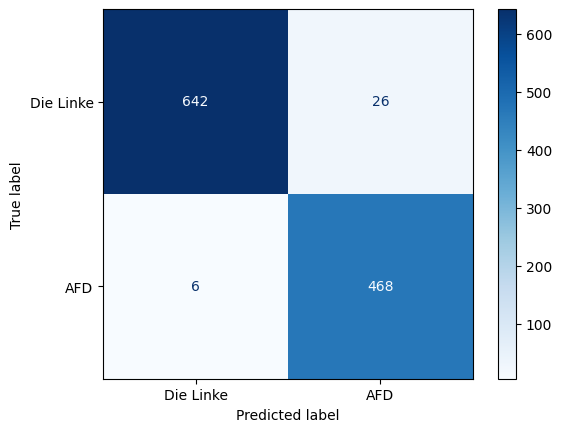

              precision    recall  f1-score   support

   Die Linke       0.95      0.99      0.97       474
         AFD       0.99      0.96      0.98       668

    accuracy                           0.97      1142
   macro avg       0.97      0.97      0.97      1142
weighted avg       0.97      0.97      0.97      1142



In [84]:
# have test_predictions and test_labels
# measure accuracy, recall, precision, look at confusion matrix
# might have to encode test_predictions and test_labels

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(test_labels, test_prediction, labels=["Die Linke", "AFD"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Die Linke", "AFD"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(test_labels, test_prediction, target_names=["Die Linke", "AFD"]))
accuracy = ()

In [83]:
test_labels

0       Die Linke
1             AFD
2             AFD
3       Die Linke
4             AFD
          ...    
1137    Die Linke
1138          AFD
1139    Die Linke
1140    Die Linke
1141          AFD
Name: labels, Length: 1142, dtype: object

Saving the model to use with Gradio <br>
See the documentation [save() and load()](https://radimrehurek.com/gensim/models/word2vec.html#:~:text=Once%20you're%20finished%20training,load_word2vec_format())

In [90]:
model.save("refined_political_doc2vec.model")

## Applying a `RandomForest`classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from data_utils import classification_error, display_confusion_matrix


In [ ]:
print(train_df)
print(test_df)

converting datasets to vectors

In [56]:
#Create feature vectors from your documents
def create_doc_vectors(documents, model):
    return np.array([infer_vector(model, doc) for doc in documents])

# Create training features
X_train = create_doc_vectors(train_df["transcript"], model)
y_train = train_df["labels"]

# Create test features
X_test = create_doc_vectors(test_df["transcript"], model)
y_test = test_df["labels"]

In [ ]:
# RandomForest 
# Train

## change some parameters to experiment that the tree does not go to deep!
rf_model = RandomForestClassifier(random_state=42)

# Create a model that classifies speeches based on vectors from the model
rf_model.fit(X_train, y_train)

## 6. Run the model on the training data
train_predicted = rf_model.predict(X_train)

## 7. Measure error
classification_error(y_train, train_predicted)

0.0

In [60]:
## 7. Measure error
classification_error(y_train, train_predicted)

0.0

In [ ]:
## test

## 6. Run the model on the test data
test_predicted = rf_model.predict(X_test)

## 7. Measure error
classification_error(y_test, test_predicted)
# print(test_predicted[1000])

Die Linke


In [81]:
print(y_test.unique())

['Die Linke' 'AFD']


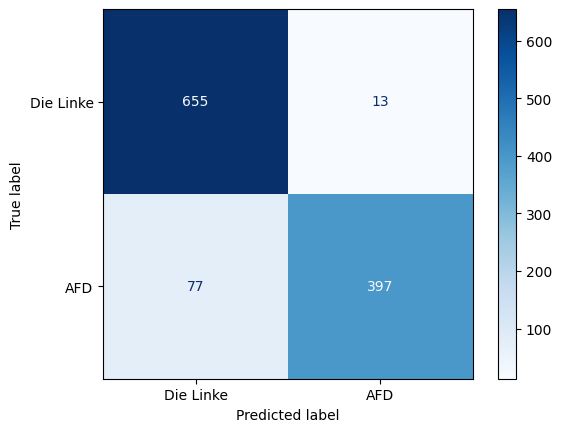

In [ ]:
cm_rf = confusion_matrix(y_test, test_predicted, labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(test_df["labels"].value_counts())

labels
Die Linke    668
AFD          474
Name: count, dtype: int64
